## Lauren Thompson
## DSC630 Final
## Predictive Analysis of Attrition

In [1]:
#imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pickle

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

from xgboost import XGBClassifier

In [2]:
#File readin
df = pd.read_csv('HR.csv')

### General Inspection

In [3]:
df.shape

(14999, 10)

In [4]:
# checking columns to ensure naming is snake case
df.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'Department', 'salary'],
      dtype='object')

In [5]:
# checking data types and null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [6]:
# General statistical view
df.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


### Cleaning Data

In [7]:
# checking for duplicates
df[df.duplicated()==True]

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
396,0.46,0.57,2,139,3,0,1,0,sales,low
866,0.41,0.46,2,128,3,0,1,0,accounting,low
1317,0.37,0.51,2,127,3,0,1,0,sales,medium
1368,0.41,0.52,2,132,3,0,1,0,RandD,low
1461,0.42,0.53,2,142,3,0,1,0,sales,low
...,...,...,...,...,...,...,...,...,...,...
14994,0.40,0.57,2,151,3,0,1,0,support,low
14995,0.37,0.48,2,160,3,0,1,0,support,low
14996,0.37,0.53,2,143,3,0,1,0,support,low
14997,0.11,0.96,6,280,4,0,1,0,support,low


There are 3008 rows that are duplicated 

In [8]:
print(round(100*(3008/len(df)), 2),'%')

20.05 %


These duplicates account for 20.05% of the dataset, removing them will ensure the data is not inflated in any one area or contains bias. 

In [9]:
df.drop_duplicates(inplace = True)
df.duplicated().any()

False

In [10]:
# Checking for missing data
df.isnull().any()

satisfaction_level       False
last_evaluation          False
number_project           False
average_montly_hours     False
time_spend_company       False
Work_accident            False
left                     False
promotion_last_5years    False
Department               False
salary                   False
dtype: bool

In [11]:
df['Department'] = df['Department'].astype('category')
df['salary'] = df['salary'].astype('category')
df.dtypes

satisfaction_level        float64
last_evaluation           float64
number_project              int64
average_montly_hours        int64
time_spend_company          int64
Work_accident               int64
left                        int64
promotion_last_5years       int64
Department               category
salary                   category
dtype: object

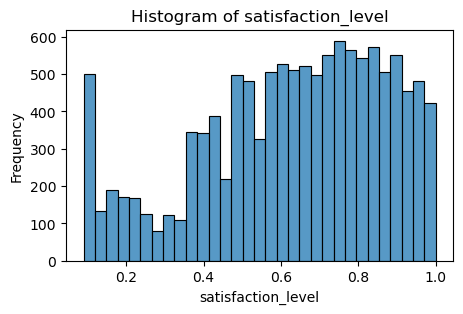

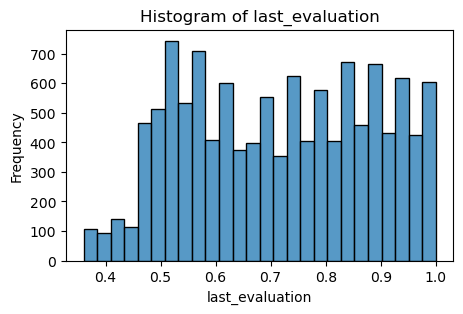

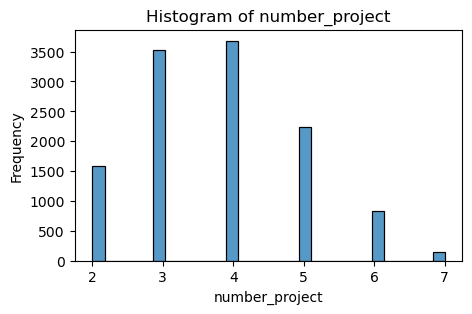

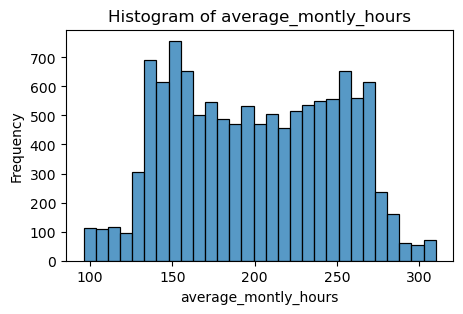

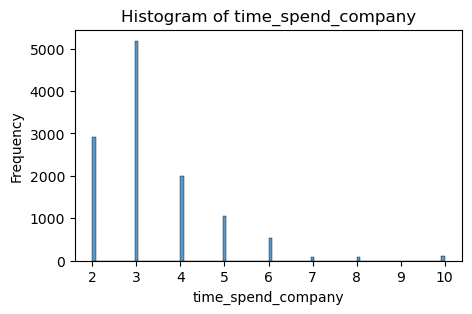

In [12]:
# Checking for outliers using histograms

histograms = df.drop(['salary', 'Department',
                             'promotion_last_5years', 
                             'left','Work_accident'], axis=1)
for column in histograms.columns:
    
    plt.figure(figsize=(5, 3))
    sns.histplot(histograms[column]) 
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

In [13]:
# Renaming columns to increase readability 
df.rename(columns=({'last_evaluation': 'evaluation_score',
    'number_project': 'project_count',
    'average_montly_hours': 'monthly_hours',
    'time_spend_company': 'tenure',
    'Work_accident': 'had_accident',
    'promotion_last_5years': 'had_promotion',
    'Department': 'department',
    'salary': 'salary_level'}), inplace=True)
df.head()

,satisfaction_level,evaluation_score,project_count,monthly_hours,tenure,had_accident,left,had_promotion,department,salary_level
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [14]:
# Creating a work intensity column based on number of projects and hours worked
df['work_intensity'] = df['project_count'] * df['monthly_hours']
df.head()

,satisfaction_level,evaluation_score,project_count,monthly_hours,tenure,had_accident,left,had_promotion,department,salary_level,work_intensity
0,0.38,0.53,2,157,3,0,1,0,sales,low,314
1,0.80,0.86,5,262,6,0,1,0,sales,medium,1310
2,0.11,0.88,7,272,4,0,1,0,sales,medium,1904
3,0.72,0.87,5,223,5,0,1,0,sales,low,1115
4,0.37,0.52,2,159,3,0,1,0,sales,low,318


### Preliminary Analysis

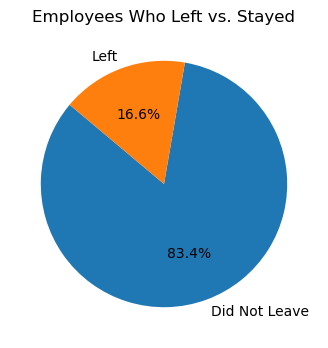

In [15]:
#Count values in left column
left_count = df['left'].value_counts()


labels = ['Did Not Leave', 'Left']
sizes = left_count.values
plt.figure(figsize=(4, 4))
plt.pie(sizes, labels=labels, autopct='%1.1f%%',startangle=140)
plt.title('Employees Who Left vs. Stayed')
plt.show()

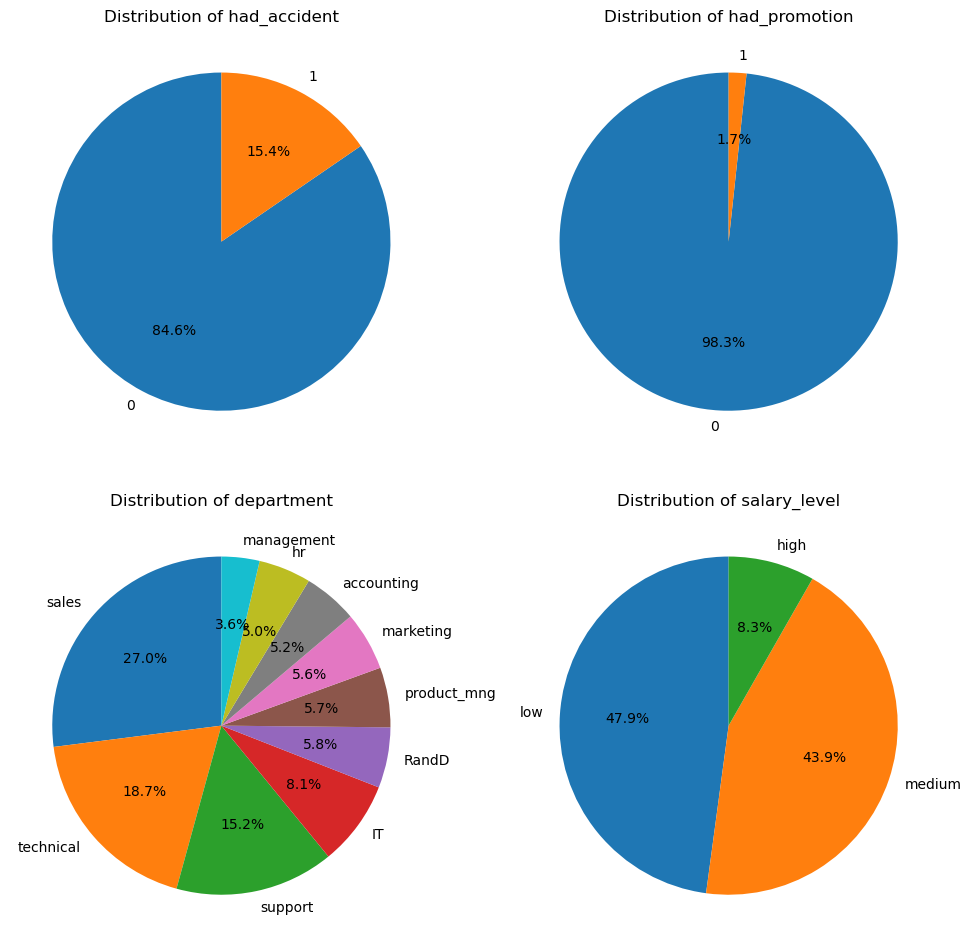

In [16]:
#Creating a loop to visualize remaining categorical columns 

categorical_columns = ['had_accident', 'had_promotion', 'department', 'salary_level']

# Create a figure and axis for subplots
fig, axes = plt.subplots(len(categorical_columns) // 2, 2, figsize=(12, 6 * (len(categorical_columns) // 2)))
plt.subplots_adjust(hspace=0.1)

for i, column in enumerate(categorical_columns):
    row_idx = i // 2
    col_idx = i % 2
    
    column_counts = df[column].value_counts()
    
    ax = axes[row_idx, col_idx]
    ax.pie(column_counts, labels=column_counts.index, autopct='%1.1f%%', startangle=90)
    ax.set_title(f'Distribution of {column}')

plt.show()


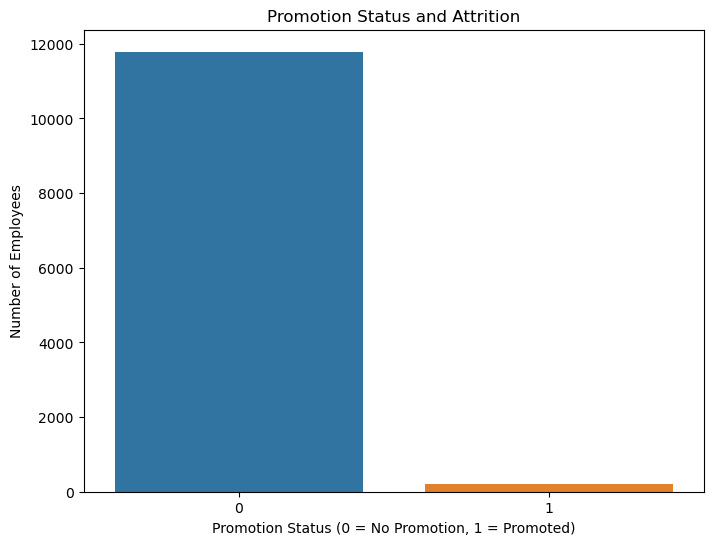

In [17]:
#barplot on promotion status vs attrition
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='had_promotion')
plt.title('Promotion Status and Attrition')
plt.xlabel('Promotion Status (0 = No Promotion, 1 = Promoted)')
plt.ylabel('Number of Employees')

plt.show()

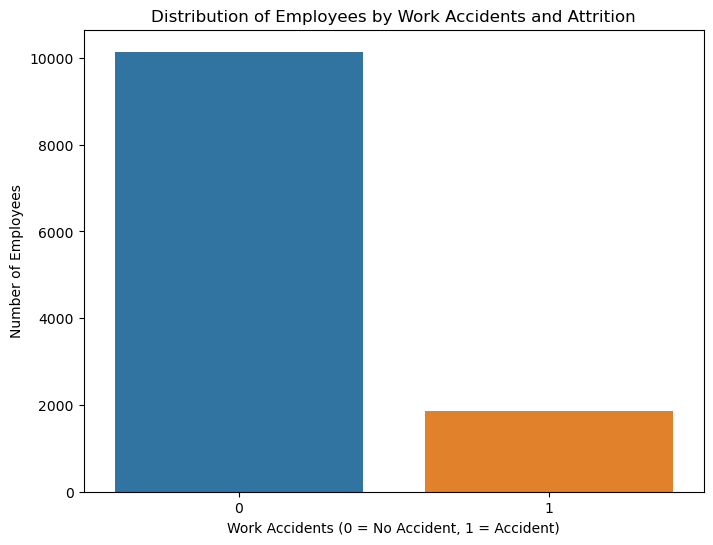

In [18]:
#accidents vs left 
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='had_accident')
plt.title('Distribution of Employees by Work Accidents and Attrition')
plt.xlabel('Work Accidents (0 = No Accident, 1 = Accident)')
plt.ylabel('Number of Employees')

plt.show()

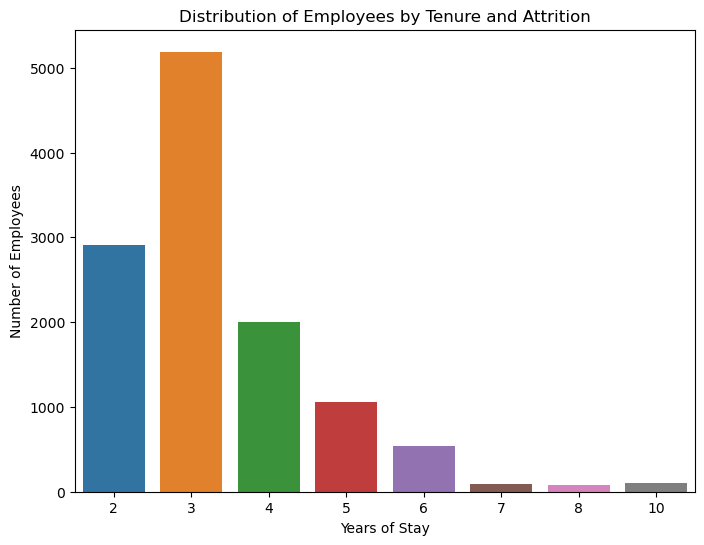

In [19]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='tenure')
plt.title('Distribution of Employees by Tenure and Attrition')
plt.xlabel('Years of Stay')
plt.ylabel('Number of Employees')

plt.show()

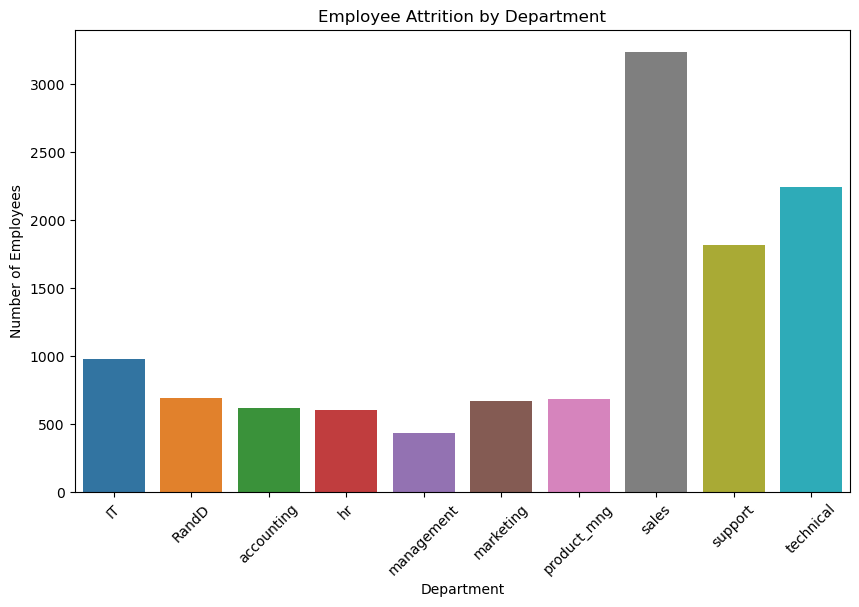

In [20]:
#attrition by department
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='department')
plt.title('Employee Attrition by Department')
plt.xlabel('Department')
plt.ylabel('Number of Employees')
plt.xticks(rotation=45)  


plt.show()

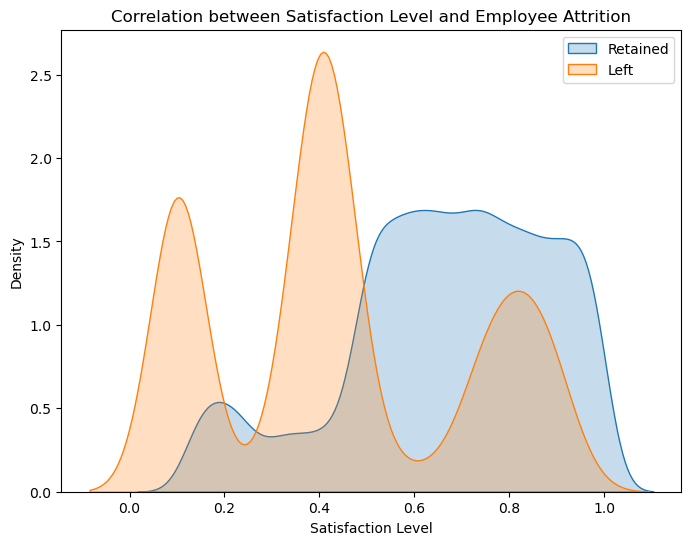

In [21]:
#Satisfaction level vs attrition
plt.figure(figsize=(8, 6))
sns.kdeplot(data=df[df['left'] == 0]['satisfaction_level'], label='Retained', fill=True)
sns.kdeplot(data=df[df['left'] == 1]['satisfaction_level'], label='Left', fill=True)
plt.title('Correlation between Satisfaction Level and Employee Attrition')
plt.xlabel('Satisfaction Level')
plt.ylabel('Density')
plt.legend()

plt.show()

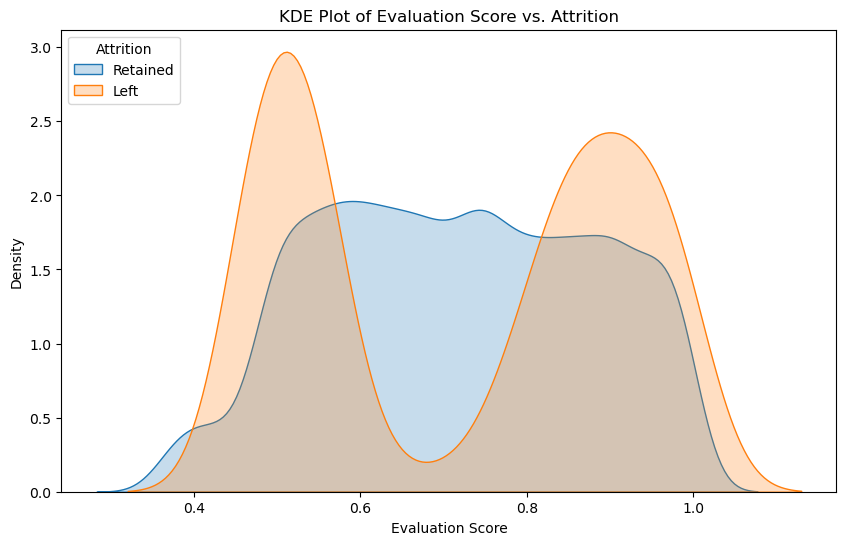

In [22]:
#evaluation score vs attrition
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df[df['left'] == 0]['evaluation_score'], label='Retained', fill=True)
sns.kdeplot(data=df[df['left'] == 1]['evaluation_score'], label='Left', fill=True)
plt.title('KDE Plot of Evaluation Score vs. Attrition')
plt.xlabel('Evaluation Score')
plt.ylabel('Density')
plt.legend(title='Attrition', loc='upper left', labels=['Retained', 'Left'])

plt.show()

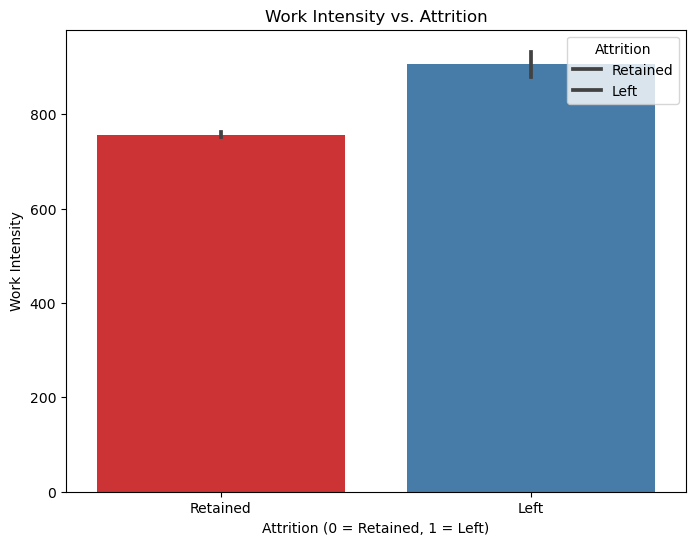

In [23]:
#Work intensity vs attrition
plt.figure(figsize=(8, 6))
sns.barplot(data= df, x='left', y='work_intensity',palette='Set1')
plt.title('Work Intensity vs. Attrition')
plt.xlabel('Attrition (0 = Retained, 1 = Left)')
plt.ylabel('Work Intensity')
plt.xticks(ticks=[0, 1], labels=['Retained', 'Left'])
plt.legend(title='Attrition', loc='upper right', labels=['Retained', 'Left'])
plt.show()

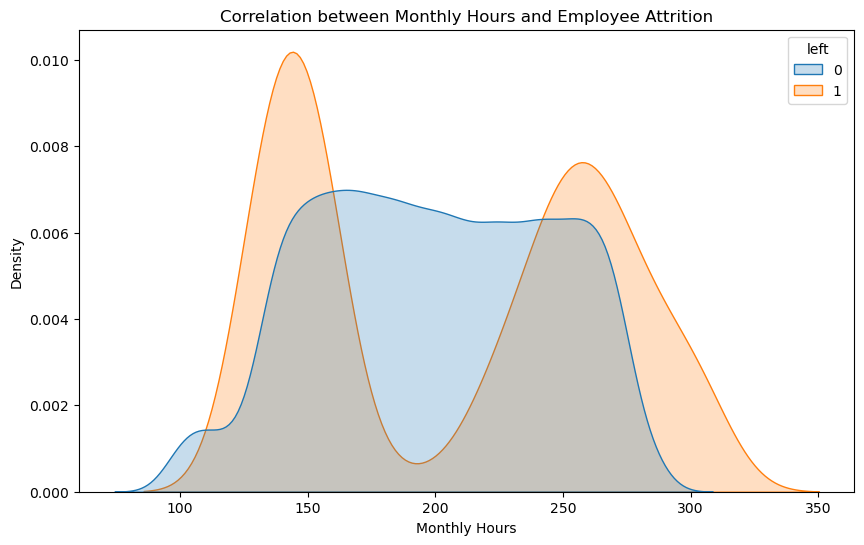

In [24]:
#monthly hours vs attrition
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='monthly_hours', hue='left', common_norm=False, fill=True)
plt.title('Correlation between Monthly Hours and Employee Attrition')
plt.xlabel('Monthly Hours')
plt.ylabel('Density')
plt.show()

In [25]:
df['overtime'] = (df['monthly_hours'] > 174).astype(int)
df.head()

,satisfaction_level,evaluation_score,project_count,monthly_hours,tenure,had_accident,left,had_promotion,department,salary_level,work_intensity,overtime
0,0.38,0.53,2,157,3,0,1,0,sales,low,314,0
1,0.80,0.86,5,262,6,0,1,0,sales,medium,1310,1
2,0.11,0.88,7,272,4,0,1,0,sales,medium,1904,1
3,0.72,0.87,5,223,5,0,1,0,sales,low,1115,1
4,0.37,0.52,2,159,3,0,1,0,sales,low,318,0


### Transformations

In [26]:
hr_data_encoded = pd.get_dummies(df, columns=['department'], prefix='department')
hr_data_encoded.head()

,satisfaction_level,evaluation_score,project_count,monthly_hours,tenure,had_accident,left,had_promotion,salary_level,work_intensity,...,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,1,0,low,314,...,False,False,False,False,False,False,False,True,False,False
1,0.80,0.86,5,262,6,0,1,0,medium,1310,...,False,False,False,False,False,False,False,True,False,False
2,0.11,0.88,7,272,4,0,1,0,medium,1904,...,False,False,False,False,False,False,False,True,False,False
3,0.72,0.87,5,223,5,0,1,0,low,1115,...,False,False,False,False,False,False,False,True,False,False
4,0.37,0.52,2,159,3,0,1,0,low,318,...,False,False,False,False,False,False,False,True,False,False


In [27]:
label_encoder = LabelEncoder()
hr_data_encoded['salary_level_encoded'] = label_encoder.fit_transform(hr_data_encoded['salary_level'])
hr_data_encoded.drop(columns=['salary_level'], inplace=True)
hr_data_encoded.head()

,satisfaction_level,evaluation_score,project_count,monthly_hours,tenure,had_accident,left,had_promotion,work_intensity,overtime,...,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,salary_level_encoded
0,0.38,0.53,2,157,3,0,1,0,314,0,...,False,False,False,False,False,False,True,False,False,1
1,0.80,0.86,5,262,6,0,1,0,1310,1,...,False,False,False,False,False,False,True,False,False,2
2,0.11,0.88,7,272,4,0,1,0,1904,1,...,False,False,False,False,False,False,True,False,False,2
3,0.72,0.87,5,223,5,0,1,0,1115,1,...,False,False,False,False,False,False,True,False,False,1
4,0.37,0.52,2,159,3,0,1,0,318,0,...,False,False,False,False,False,False,True,False,False,1


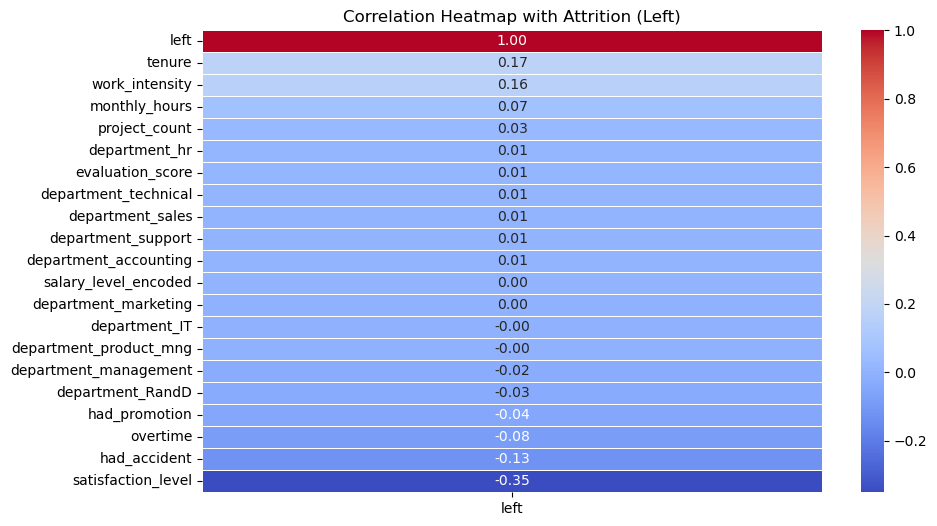

In [28]:
correlation_matrix = hr_data_encoded.corr(method='pearson')

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix[['left']].sort_values(by='left', ascending=False), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap with Attrition (Left)")
plt.show()

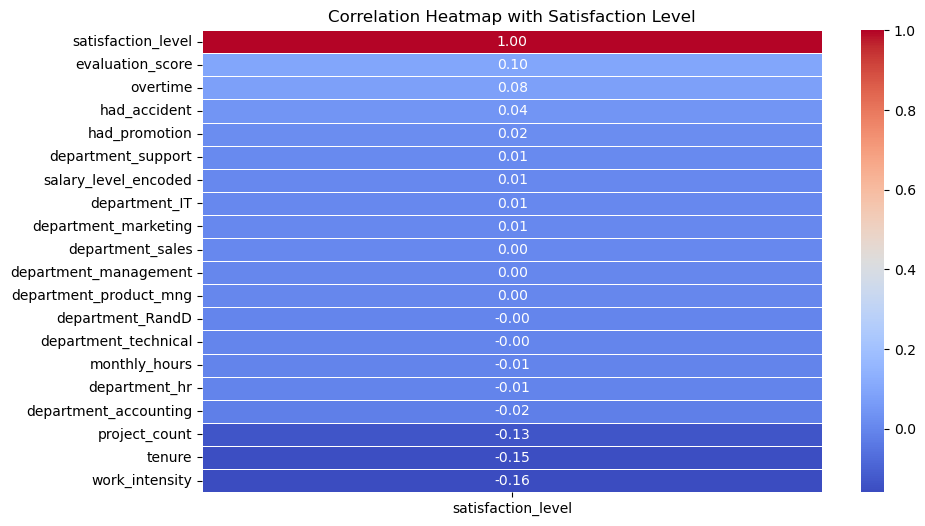

In [29]:
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix.drop('left')[['satisfaction_level']].sort_values(by='satisfaction_level', ascending=False), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap with Satisfaction Level")
plt.show()

In [30]:
columns_to_drop = [
    'department_IT', 'department_RandD', 'department_accounting',
    'department_hr', 'department_management', 'department_marketing',
    'department_product_mng', 'department_sales', 'department_support',
    'department_technical'
]

hr_data_encoded.drop(columns=columns_to_drop, inplace=True)

In [31]:
hr_data_encoded.head()

,satisfaction_level,evaluation_score,project_count,monthly_hours,tenure,had_accident,left,had_promotion,work_intensity,overtime,salary_level_encoded
0,0.38,0.53,2,157,3,0,1,0,314,0,1
1,0.80,0.86,5,262,6,0,1,0,1310,1,2
2,0.11,0.88,7,272,4,0,1,0,1904,1,2
3,0.72,0.87,5,223,5,0,1,0,1115,1,1
4,0.37,0.52,2,159,3,0,1,0,318,0,1


In [32]:
hr_data_encoded['work_life_balance'] = hr_data_encoded['satisfaction_level'] / (hr_data_encoded['monthly_hours'] * hr_data_encoded['tenure'])
hr_data_encoded.head()

,satisfaction_level,evaluation_score,project_count,monthly_hours,tenure,had_accident,left,had_promotion,work_intensity,overtime,salary_level_encoded,work_life_balance
0,0.38,0.53,2,157,3,0,1,0,314,0,1,0.000807
1,0.80,0.86,5,262,6,0,1,0,1310,1,2,0.000509
2,0.11,0.88,7,272,4,0,1,0,1904,1,2,0.000101
3,0.72,0.87,5,223,5,0,1,0,1115,1,1,0.000646
4,0.37,0.52,2,159,3,0,1,0,318,0,1,0.000776


### Constructing Models

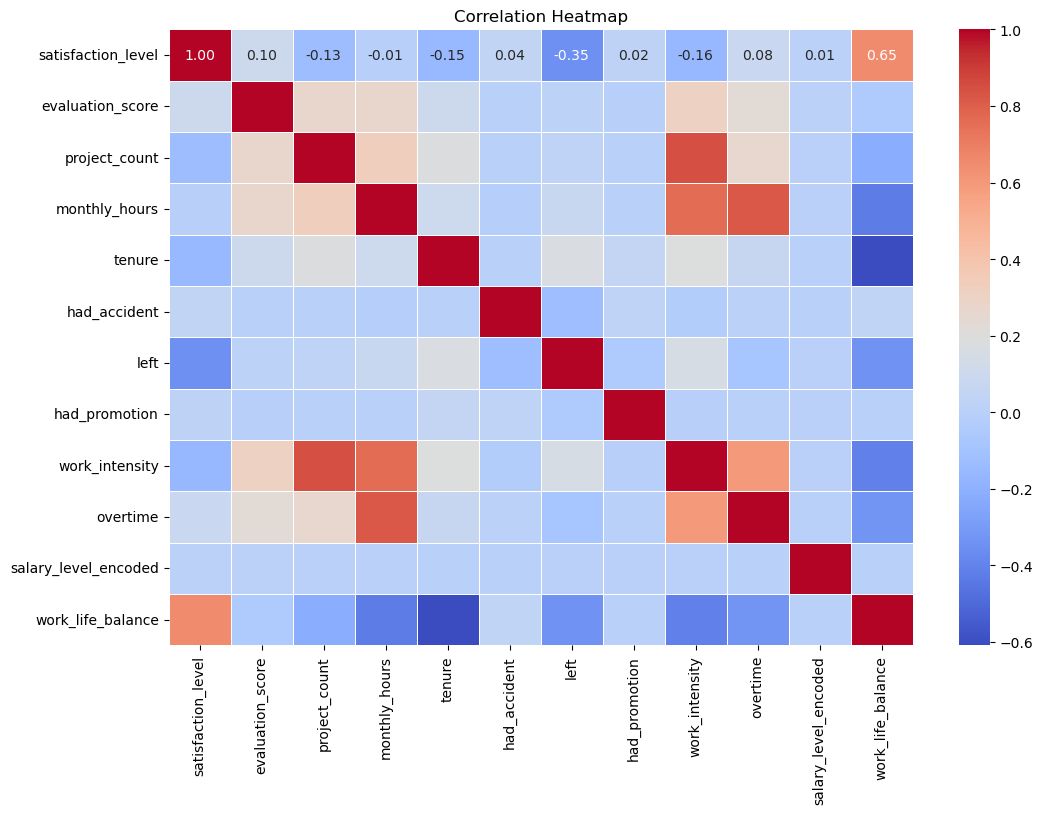

In [33]:
correlation_matrix = hr_data_encoded.corr(method='pearson')

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

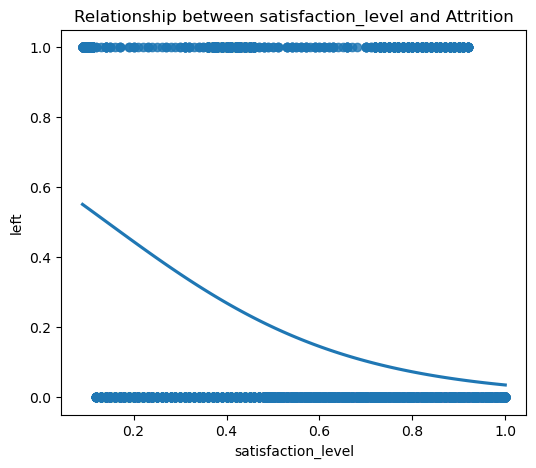

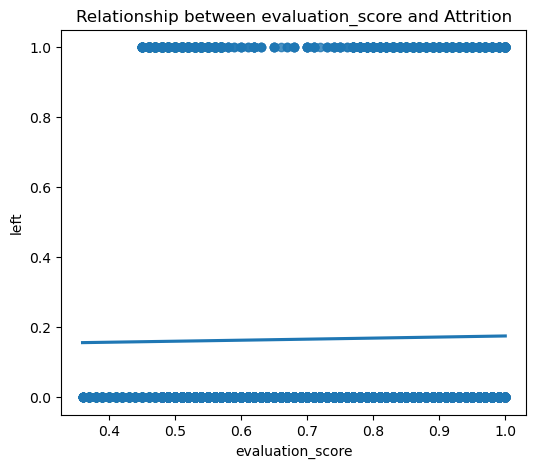

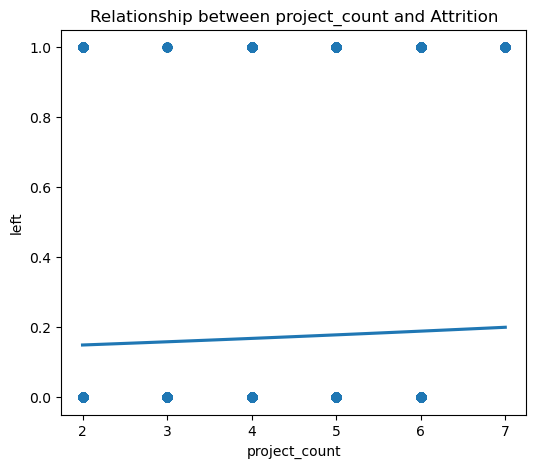

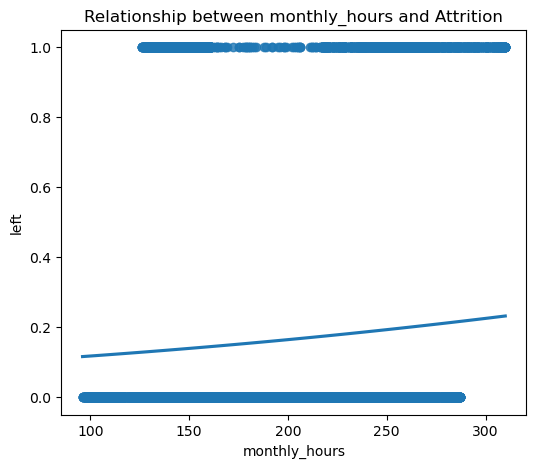

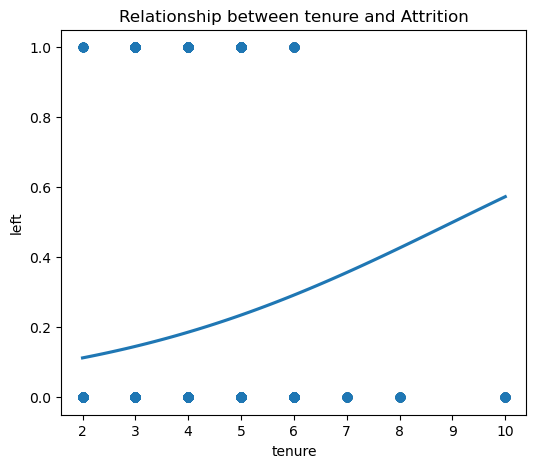

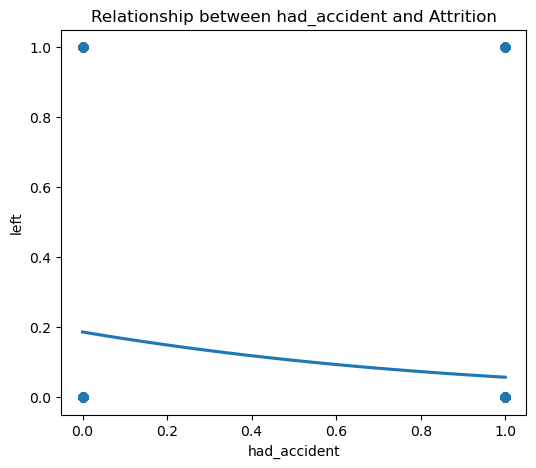

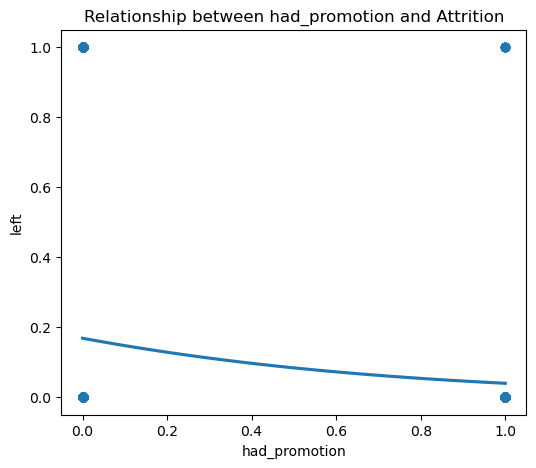

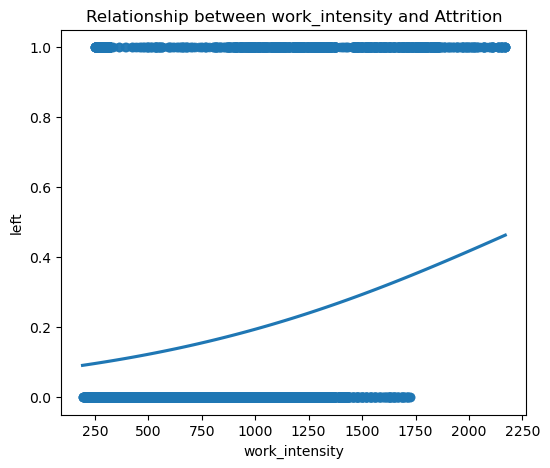

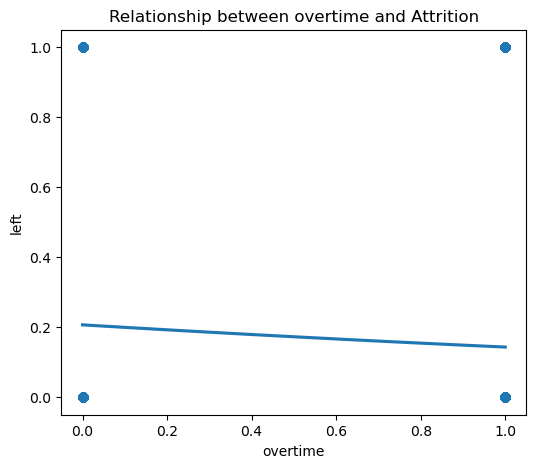

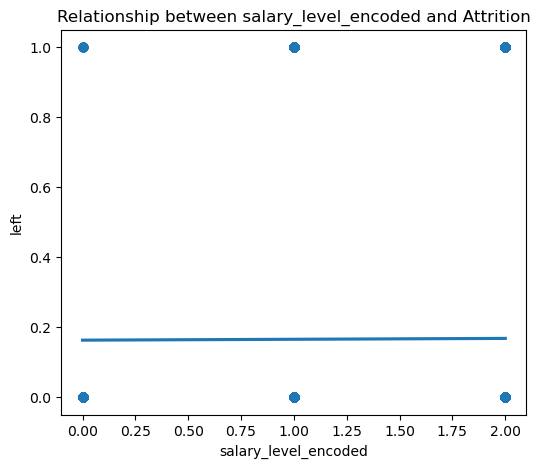

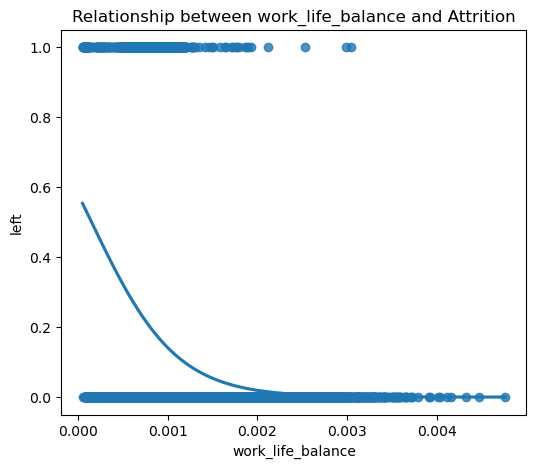

In [34]:
predictor_variables = ['satisfaction_level', 'evaluation_score', 'project_count',
                       'monthly_hours', 'tenure', 'had_accident', 'had_promotion',
                       'work_intensity', 'overtime', 'salary_level_encoded',
                       'work_life_balance']

for var in predictor_variables:
    plt.figure(figsize=(6, 5))
    sns.regplot(data=hr_data_encoded, x=var, y='left', logistic=True, ci=None)
    plt.title(f'Relationship between {var} and Attrition')
    plt.xlabel(var)
    plt.show()

#### Logistic Regression

In [35]:
#Define our predictor variables(X) and outcome variable (y)
X = hr_data_encoded.drop(columns=['left'])
y = hr_data_encoded['left']

In [36]:
#Split our data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = 0)
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)
print("X_val:", X_val.shape)
print("y_val:", y_val.shape)

X_train: (8993, 11)
y_train: (8993,)
X_test: (2998, 11)
y_test: (2998,)
X_val: (2249, 11)
y_val: (2249,)


In [37]:
#Train our model

clf = LogisticRegression(max_iter = 1000,random_state=42)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

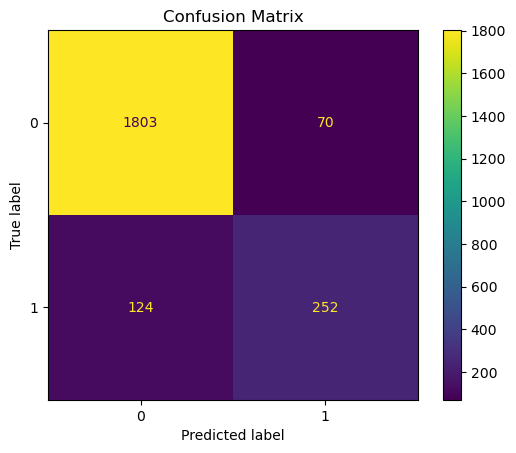

In [38]:
#Test on valuation set with confusion matrix

#save predictions
y_val_pred = clf.predict(X_val)

cm = confusion_matrix(y_val, y_val_pred, labels=clf.classes_)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot( values_format='d')

plt.title('Confusion Matrix')
plt.show()

In [39]:
#checking metric scores

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)

print("Accuracy:", round(accuracy,2))
print("Precision:", round(precision,2))
print("Recall:", round(recall,2))
print("F1 Score:", round(f1,2))

Accuracy: 0.91
Precision: 0.78
Recall: 0.67
F1 Score: 0.72


In [40]:
#save model
with open('logistic_regression_model.pkl', 'wb') as model_file:
    pickle.dump(clf, model_file)

### Tuned Random Forest

In [41]:
# Define the hyperparameter grid 
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}


#list of Scoring metrics
scoring = ["accuracy", "precision", "recall", "f1"]

# Create the grid search object
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring=scoring,
    refit="recall",  # focus on reducing false negatives because we want to predict which employees are leaving 
)

# Fit model
grid_search.fit(X_train, y_train)

#Get best parameters
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Evaluate performance on validation set
y_val_pred = best_model.predict(X_val)

#Get results
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)


print("Accuracy:", round(accuracy,2))
print("Precision:", round(precision,2))
print("Recall:", round(recall,2))
print("F1 Score:", round(f1,2))

Accuracy: 0.99
Precision: 1.0
Recall: 0.94
F1 Score: 0.97


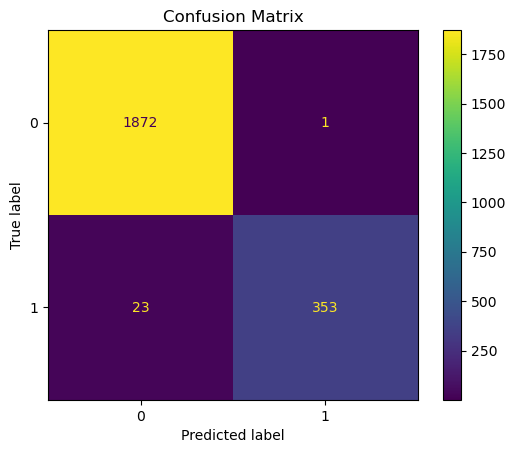

In [42]:
cm = confusion_matrix(y_val, y_val_pred, labels=clf.classes_)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot( values_format='d')

plt.title('Confusion Matrix')
plt.show()

In [43]:
#save model
with open('random_forest_model.pkl', 'wb') as model_file:
    pickle.dump(best_model, model_file)

### XGBoost

In [44]:
param_grid = {"n_estimators" : [50, 100, 200],
             "max_depth" : [5, 8, None],
             "min_child_weight" : [3, 5],
             "learning_rate" : [0.1, 0.2, 0.3],
             "subsample" : [0.75],
             "colsample_bytree" : [0.75]}

#List of scoring metrics
scoring = ["accuracy", "precision", "recall", "f1"]

# Create the grid search object
grid_search = GridSearchCV(
    XGBClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring=scoring,
     n_jobs = -1,
     verbose = 1,
    refit="recall",  # focus on reducing false negatives because we want to predict which employees are leaving 
)


# Fit model
grid_search.fit(X_train, y_train)

#Get best parameters
best_params = grid_search.best_params_
best_XGmodel = grid_search.best_estimator_

# Evaluate performance on validation set
y_val_pred = best_XGmodel.predict(X_val)

#Get results
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)

print("Accuracy:", round(accuracy,2))
print("Precision:", round(precision,2))
print("Recall:", round(recall,2))
print("F1 Score:", round(f1,2))

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Accuracy: 0.99
Precision: 1.0
Recall: 0.96
F1 Score: 0.98


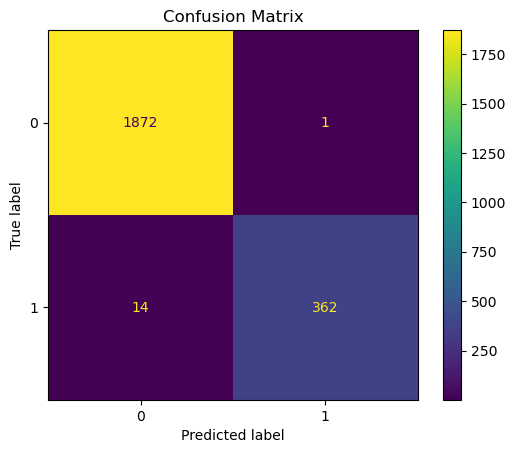

In [45]:
cm = confusion_matrix(y_val, y_val_pred, labels=clf.classes_)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot( values_format='d')

plt.title('Confusion Matrix')
plt.show()

In [46]:
#save model
with open('xgboost_model.pkl', 'wb') as model_file:
    pickle.dump(best_XGmodel, model_file)

## Model Evaluation

In [47]:
#Define empty score list
score_list = []

#Define a list of model names and their corresponding saved model file names
model_info = [
    {'name': 'Logistic Regression', 'filename': 'logistic_regression_model.pkl'},
    {'name': 'Random Forest', 'filename': 'random_forest_model.pkl'},
    {'name': 'XGBoost', 'filename': 'xgboost_model.pkl'}
]

#Loop and load each model
for model_info in model_info:
    model_name = model_info['name']
    model_filename = model_info['filename']

    with open(model_filename, 'rb') as model_file:
        loaded_model = pickle.load(model_file)

    #Use loaded models on test data
    y_test_pred = loaded_model.predict(X_test)

    #Metrics
    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)

    #Append the scores to the list as a dictionary
    score_list.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })

score_df = pd.DataFrame(score_list)
score_df.head()

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.907272,0.733173,0.646186,0.686937
1,Random Forest,0.984990,0.975501,0.927966,0.951140
2,XGBoost,0.982322,0.954447,0.932203,0.943194


In [48]:
# Load the Random Forest model from the pickle file
with open('random_forest_model.pkl', 'rb') as model_file:
    loaded_model = pickle.load(model_file)

#Get feature importances
feature_importances = loaded_model.feature_importances_

feature_names = X_train.columns 

#Nake df and sort by highest
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)


print("Top Features Contributing to Attrition Prediction:")
print(feature_importance_df)

Top Features Contributing to Attrition Prediction:
                 Feature  Importance
7         work_intensity    0.260586
0     satisfaction_level    0.230016
10     work_life_balance    0.162971
4                 tenure    0.106109
1       evaluation_score    0.077315
3          monthly_hours    0.077201
2          project_count    0.072098
8               overtime    0.007788
9   salary_level_encoded    0.002942
5           had_accident    0.002569
6          had_promotion    0.000405
